<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod6/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod6/cnn.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Deep Computer Vision Using Convolutional Neural Networks
---
_homl3 ch14_

Convolutional neural networks (CNNs) powers various applications:

- visual perception based applications such as
  - image search services, self-driving cars, automatic video classification systems
  - `object detection`
    - classify multiple objects in an image and place bounding boxes around them
  - `semantic segmentation`
    - classify each pixel according to the class of the object it belongs to
- other applications with hierarchical structures such as
  - voice recognition and natural language processing 


In [9]:
# Colab: Go to Runtime > Change runtime and select a GPU hardware
# Kaggle: Go to Settings > Accelerator and select GPU
# ⚠️ unfortunately, depthwise max pooling is currently only implemented for CPU devices (2024)
# three of the ceils below will NOT work on GPU
# so it is better stick to CPU for demonstration purpose
import sys, math
from functools import partial
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds, tensorflow as tf
from sklearn.datasets import load_sample_images

# The Architecture of the Visual Cortex
is a `structure of layers` that higher-level neurons are based on the outputs of neighboring lower-level neurons (p1):
- some neurons have a small `local receptive` field
  - they react only to visual stimuli located in a `limited region` of the visual field
  - The receptive fields of different neurons may overlap together they tile the whole visual field
  - some neurons react only to images of horizontal lines
    - while others react only to lines with different orientations
  - two neurons may have the same receptive field but react to different line orientations
- other neurons have larger receptive fields
  - they react to more `complex patterns` that are combinations of the lower-level patterns
- A DNN with fully connected layers works fine for small images such as MNIST
  - but it breaks down for larger images because of the `huge number of parameters` it requires
  - e.g. a 100x100-pixel image has 10,000 pixels, if the first layer has just 1,000 neurons
  - just this first layer, it already has 1,000x10,000=10 million parameters
  - meanwhile, from 10,000 dimensions to 1,000 dimensions, lots of information will be lost
- CNNs solve this problem using `partially connected` layers and `weight sharing`

Convolutional Layers
---
- (p2) each neuron N in a higher layer is connected to only `several neurons` in its previous layer
  - not connected to every neurons like fully connected layer
  - these `several neurons` form the `receptive field` of neuron N
- the first convolutional layer are not connected to every single pixel in the input image
  - but only to pixels in their receptive fields
  - concentrate on small low-level features
  - then assemble them into higher-level features in the next hidden layer, and so on
- each CNN layer is represented in 2D
  - easier to match neurons with their corresponding inputs
- This hierarchical structure is common in real-world images
  - which is one of the reasons why CNNs work so well for image recognition

🍎 Example 1
---
(p3) Connections between layers and zero padding
- input layer size: 5x7 (plus zero padding)
- upper layer size: 3x4
- use 3x3 receptive fields and a stride of 1
- A neuron located in `row i, column j` of a given layer is connected to the outputs of the neurons in the previous layer located in
  - `rows i to i + fh – 1, columns j to j + fw – 1`, 
  - `fh` and `fw` are the height and width of the receptive field
- `zero padding` adds zeros around the inputs to make the same height and width as the previous layer

🍎 Example 2
---
(p4) Reducing dimensionality using a stride of 2
- input layer size: 5x7 (plus zero padding)
- upper layer size: 3x4
- use 3x3 receptive fields and a stride of 2
  - the stride may be different for the two directions
- `spacing out the receptive fields` dramatically reduces the model’s computational complexity
  - by connecting a large input layer to a much smaller layer
- The horizontal or vertical step size `from one receptive field to the next` is called the `stride`
- A neuron located in `row i, column j` of a given layer is connected to the outputs of the neurons in the previous layer located in
  - `rows i×sh to i×sh + fh – 1, columns j×sw to j×sw + fw – 1`, 
  - `sh` and `sw` are the vertical and horizontal strides

Filters
---
- filter pixels for intended pixels
  - (p5) e.g. the vertical filter looks for vertical lines is a black square with a vertical white line in the middle represented by
    - a 7 × 7 weight matrix full of 0s except for the central column, which is full of 1s
    - neurons using these weights will ignore everything in their receptive field except for the central vertical line
  - a layer full of neurons using the same filter outputs a `feature map`
    - which highlights the `areas` in an image that `activate the filter` the most
  - no need to define the filters manually
    - during training the convolutional layer will automatically learn the most useful filters for its task
    - and the layers above will learn to combine them into more complex patterns
- also called convolution kernels, or just kernels

Stacking Multiple Feature Maps
---
- (p6) a convolutional layer simultaneously applies multiple trainable filters to its inputs
  - outputs one feature map per filter
    - in order to detect multiple features anywhere in its inputs
  - has one neuron per pixel in each feature map
- all neurons within a given feature map share the same parameters
  - the same kernel and bias term
  - this dramatically reduces the number of parameters in the model
- Neurons in different feature maps use different parameters
  - extend their receptive fields across all the feature maps of the previous layer
  - mathematically, a neuron located in `row i, column j` of the `feature map k` in a given convolutional layer `ℓ` 
    - is connected to the outputs of the neurons in the previous layer `ℓ – 1`, 
    - located in `rows i × sh to i × sh + fh – 1` and `columns j × sw to j × sw + fw – 1`, 
    - across all feature maps in layer `ℓ – 1`
  - its output ${z_{i,j,k}}$ is computed with
  - ${\displaystyle z_{i,j,k} = b_k + \sum_{u=0}^{f_h - 1}\sum_{v=0}^{f_w - 1}\sum_{k'=0}^{f_{n'} - 1} x_{i',j',k'} × w_{u,v,k',k} }$
    - with ${ i'= i×s_h + u, j'=j×s_w + v }$
    - ${ f_{n'} }$ is the number of feature maps in layer `ℓ – 1`
    - ${ x_{i',j',k'} }$  is the output of the neuron located in layer `ℓ – 1`, row i', column j', feature map k'
    - bₖ is the bias term for feature map k in layer `ℓ`
    - ${ w_{u,v,k',k} }$  is the `connection weight` between any neuron in feature map k of the layer `ℓ` and its input located at row u, column v (relative to the neuron’s receptive field), and feature map k′

In [2]:
# 1. Implementing Convolutional Layers with Keras
# 1)  Let's load two sample images, rescale their pixel values to 0-1, 
#     and center crop them to small 70×120 images:, using 
#   - Scikit-Learn’s load_sample_image() function 
#   - and Keras’s CenterCrop and Rescaling layers 

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)
images.shape # [2 images, height: 70, width: 120, 3 channels]

TensorShape([2, 70, 120, 3])

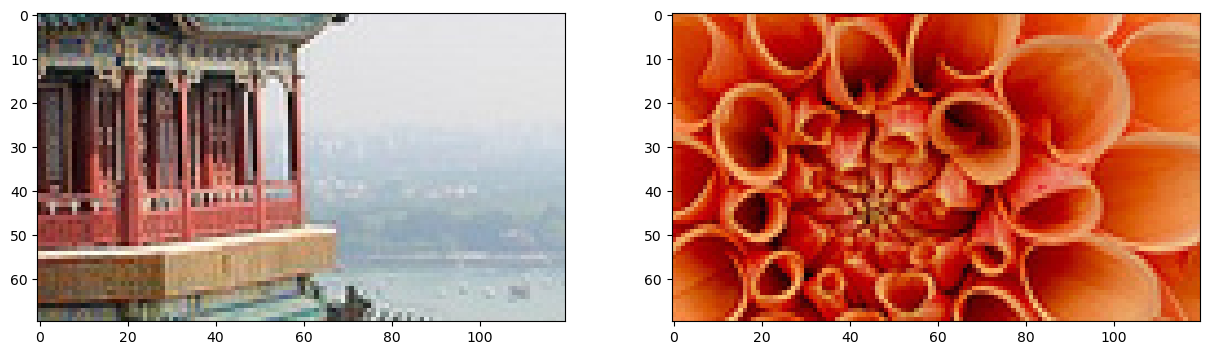

In [14]:
# 2) show the two preprocessed images
fig1, ax1 = plt.subplots(1,2, figsize=(15,4))
for i in range(2):
  ax1[i].imshow(images[i])

In [9]:
# 3) create a convolutional layer with 32 filters, 
# each of size 7 × 7 (using kernel_size=7, which is
# equivalent to using kernel_size=(7 , 7)), 
# and apply this layer to our small batch of two images

conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
fmaps.shape # [2 images, height: 64=70-6, width: 114=120-6, 32 channels]

TensorShape([2, 64, 114, 32])

- there are 32 channels because we set filters=32
- the height and width have both shrunk by 6 pixels because the Conv2D layer uses the default `valid` (view field) padding, no padding at all
  - the kernel size is 7, we lose 6 pixels horizontally and 6 pixels vertically
  - i.e., 3 pixels on each side

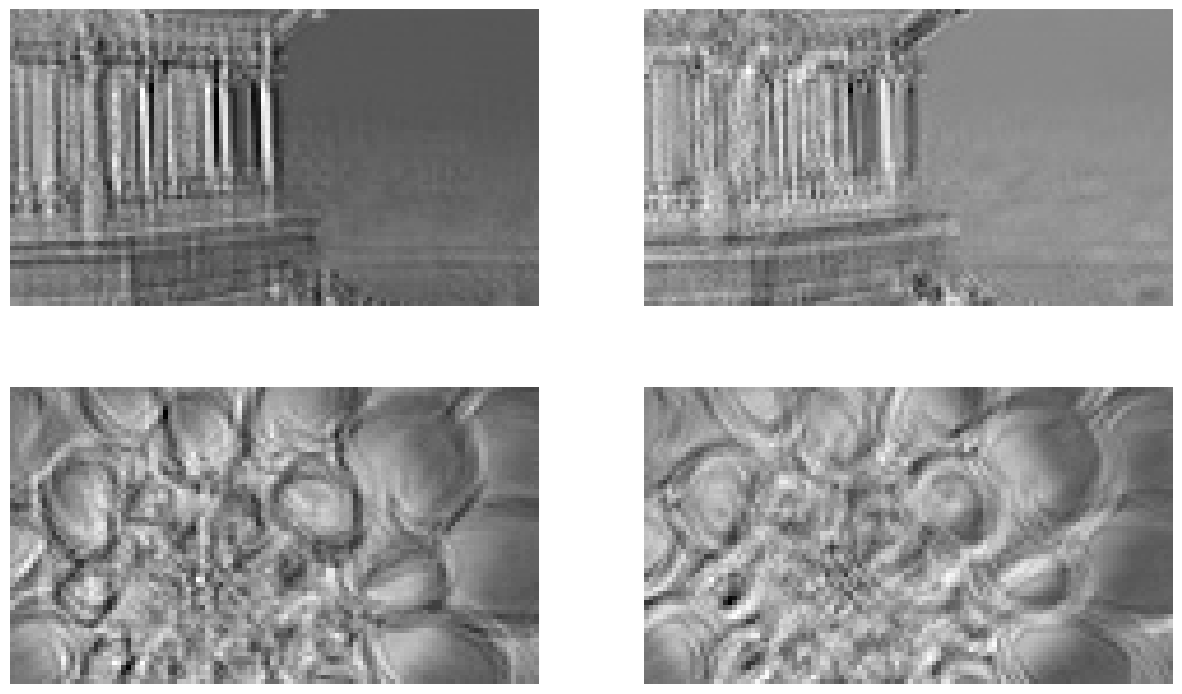

In [12]:
# 4) displays the first two output feature maps for each image
fig2, ax2 = plt.subplots(2,2, figsize=(15,9))
for images_idx in (0,1):
  for fmap_idx in (0,1):
    ax2[images_idx][fmap_idx].imshow(fmaps[images_idx, :,:, fmap_idx], cmap='gray')
    ax2[images_idx][fmap_idx].axis('off');

- randomly generated filters typically act like edge detectors, 
  - that's the type of filters that a convolutional layer typically starts with
- during training, the filters are tuned to recognize useful patterns for the task

In [13]:
# 5) set padding="same" to enable `zero padding`, 
# pad all sides with zeros to ensure that the output feature maps 
# have the `same` size as the inputs
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

- (p7) illustrates the two padding options 
  - only the horizontal dimension is shown here
- (p8) If the stride is greater than 1 (in any direction), 
  - then the output size will be smaller than the input size even if padding="same"
  - e.g. input size (70,120) by strides=(2,2) get (35,60)
- calculation the output size `(output height, output width)` = ${(o_h, o_w)}$
  - padding="valid": 
    - ${ o_h = ⌊\dfrac {i_h - f_h + s_h} {s_h} ⌋ }$
      - iₕ: input height; fₕ: kernel height; sₕ: vertical stride
      - any ignored rows are at the bottom of the input image
      - number of ignored rows: ${ (i_h - f_h + s_h)\mod s_h }$
    - ${ o_w = ⌊\dfrac {i_w - f_w + s_w} {s_w} ⌋ }$
      - ${i_w}$: input width; ${f_w}$: kernel width; ${s_w}$: horizontal stride
      - any ignored columns are on the right side of the input image
      - number of ignored columns: ${ (i_w - f_w + s_w)\mod s_w }$
  - padding="same":
    - ${ o_h = ⌈\dfrac {i_h} {s_h}⌉  }$
      - number of padded zero rows: ${ (o_h - 1)×s_h + f_h-i_h }$
    - ${ o_w = ⌈\dfrac {i_w} {s_w}⌉  }$
      - number of padded zero rows: ${ (o_w - 1)×s_w + f_w-i_w }$

In [16]:
# 6) function `conv_output_size` computes the size of the
#   feature maps output by a convolutional layer. It also returns
#   the number of ignored rows or columns if padding="valid", or the
#   number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = np.ceil((input_size - 1) / strides) 
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

ov = conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="valid")
oz = conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

ov,oz

((array([32, 57]), array([1, 1])), (array([35., 60.]), array([5., 5.])))

In [15]:
# 7) a Conv2D layer holds all the layer’s weights: kernels and biases
# - the kernels (kernel_height, kernel_width, input_channels, output_channels) 
#     are initialized randomly 
# - the biases ([output_channels,)
#     are initialized to zero

kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape

((7, 7, 3, 32), (32,))

In [36]:
# 8) create 3 filters manually, mainly used in traditional image processing
filters = np.zeros([7, 7, 3, 3])
filters[:, 3, :, 0] = 1 # vertical line filter
filters[3, :, :, 1] = 1 # horizontal line filter
filters[:, :, :, 2] = tf.random.uniform((7,7,3), minval=0, maxval=1) # random filter
biases = tf.zeros([3])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

In [41]:
filters[:, :, 0, 0], filters[:, :, 0, 1], filters[:, :, 0, 2]

(array([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]),
 array([[0.38593888, 0.3994627 , 0.37774086, 0.91810405, 0.19231582,
         0.04571724, 0.630247  ],
        [0.42151666, 0.14542663, 0.98959434, 0.0731504 , 0.34304905,
         0.01948702, 0.81536686],
        [0.67280233, 0.20614851, 0.23529434, 0.3183589 , 0.89409029,
         0.77837455, 0.18636227],
        [0.13112593, 0.62717676, 0.11409771, 0.28605938, 0.27766383,
         0.49086607, 0.69740033],
        [0.3210721 , 0.42184961, 0.43618643, 0.62381

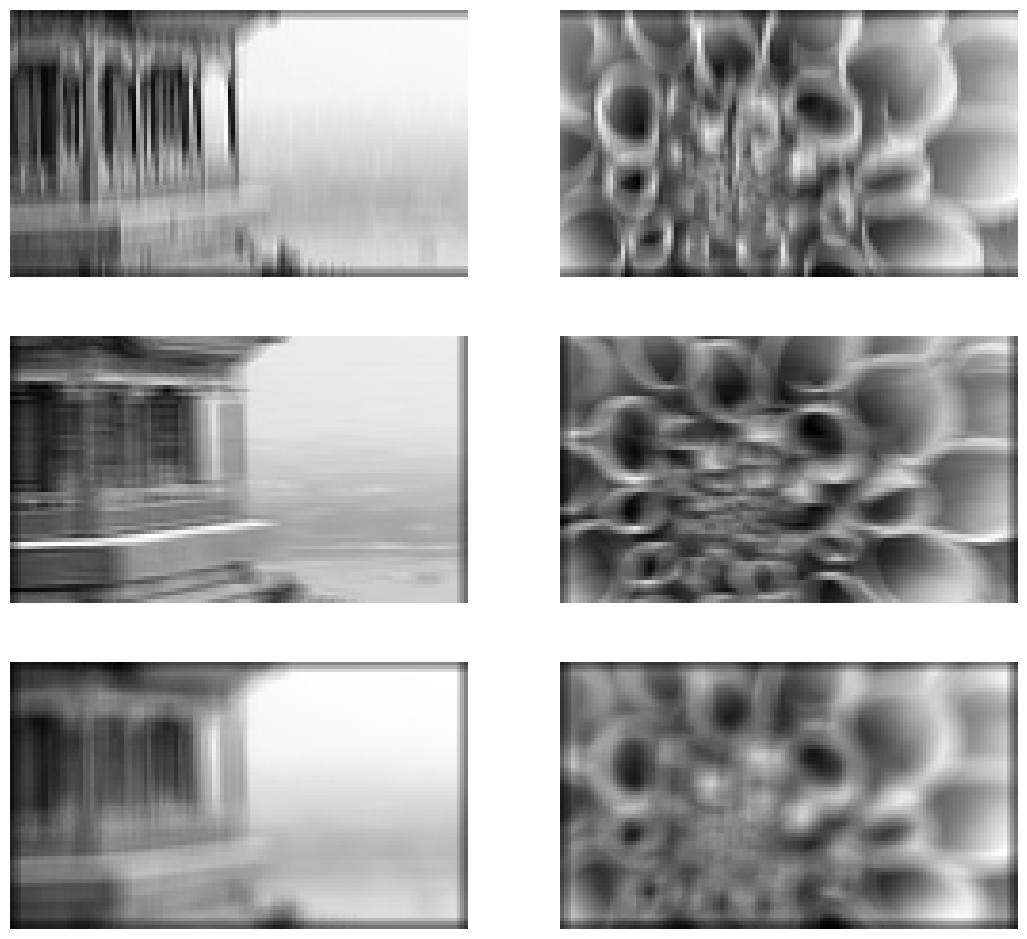

In [45]:
# visualize the filtered images, pay attend to the edge dark lines
# due to zero padding and
# the two feature maps based on the vertical line filter 
#   could not fully activate near the top and bottom of the images
# the two feature maps based on the horizontal line filter 
#   could not fully activate near the left and right of the images
# the two feature maps based on the random filter 
#   could not fully activate near all four sides of the images

fig3, ax3 = plt.subplots(3,2, figsize=(13,12))
for fmap_idx in (0, 1, 2):
  for image_idx in (0, 1):
    ax3[fmap_idx, image_idx].imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
    ax3[fmap_idx, image_idx].axis("off")

Convolutional layers require a huge amount of RAM
---
- especially during training since backprop needs to 
  - preserve all the intermediate values computed during the forward pass
- e.x. consider a convolutional layer with 200 `5 × 5` filters, stride 1 and "same" padding
  - If the input is a 150 × 100 RGB image
    - then the number of parameters is (5 × 5 × 3 + 1) × 200 = 15,200 (the `+ 1` corresponds to the bias terms)
  - each of the 200 feature maps contains 150 × 100 neurons
  - each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75 inputs: 
    - a total of 200×150 × 100×75 = 225 million float multiplications
  - if the feature maps are represented using 32-bit floats, then the convolutional layer’s output will occupy 200 × 150 × 100 × 32 = 96 million bits (12 MB) of RAM
    - And that’s just for one instance—if a training batch contains 100 instances, 
    - then this layer will use up 1.2 GB of RAM!
  - during prediction, 
    - the RAM occupied by one layer can be released as soon as the next layer has been computed, 
    - so you only need as much RAM as required by two consecutive layers

Pooling Layers
---
- subsample (i.e., shrink) the input image in order to 
   - reduce the computational load, the memory usage, the number of parameters, and risk of overfitting
- each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a `small rectangular receptive field`
  - whose size, the stride, and the padding type must be defined like before
- a pooling neuron has no weights
  - all it does is aggregate the inputs using an aggregation function such as the max or mean
- e.x. (p9)
- a max pooling layer introduces some level of `invariance` to small translations (p10)
  - By inserting a max pooling layer every few layers in a CNN, 
     - it is possible to get some level of `translation invariance` at a larger scale
  - max pooling also offers a small amount of `rotational invariance` and `scale invariance`
- the downsides of a max pooling 
  - very destructive
    - even with a tiny 2 × 2 kernel and a stride of 2, 
    - the output will be two times smaller in both directions
    -  its area will be four times smaller, i.e. 75% of the input values are dropped
  - invariance is not desirable in some applications such as semantic segmentation


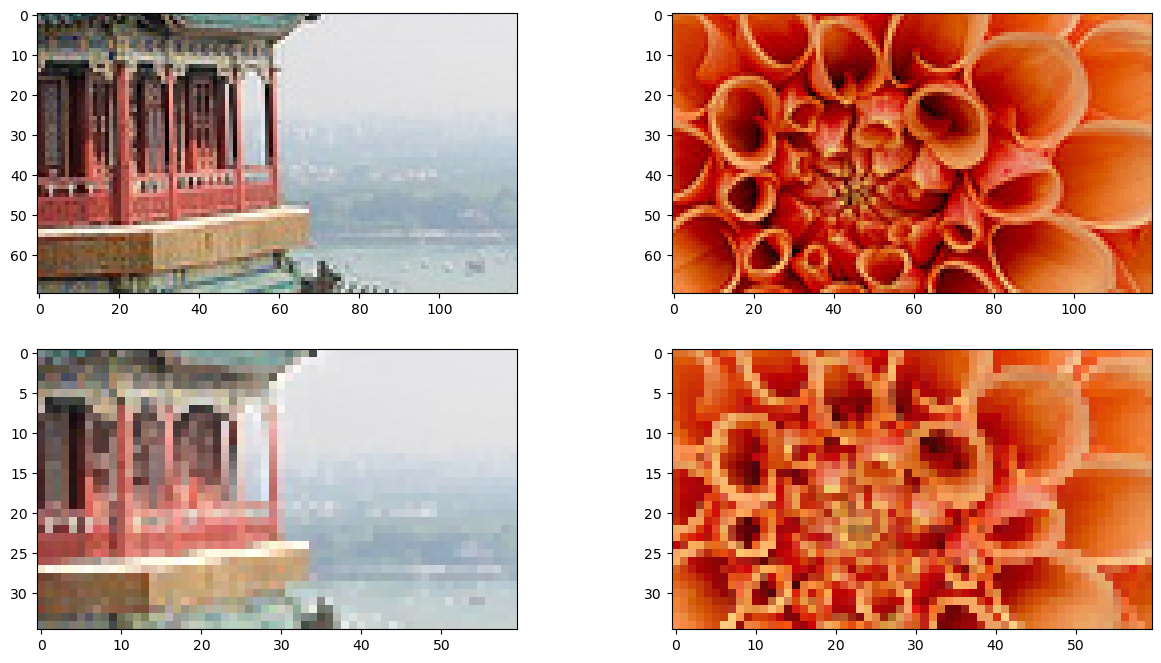

In [51]:
# 1. Create a maxpooling layer with MaxPool2D, using a 2 × 2 kernel. 
# 1) The strides default to the kernel size, 
# so this layer uses a stride of 2 (horizontally and vertically).
# By default, it uses "valid" padding, i.e. no padding at all

max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

# 2) apply it to the two sample images
outputs = max_pool(images)

# 3) visualize the two images vs their maxpooled images
# pay attention to the axises, output size = input size / 2
fig4, ax4 = plt.subplots(2,2, figsize=(15,8))
for i in range(2):
  ax4[0,i].imshow(images[i])
for i in range(2):
  ax4[1,i].imshow(outputs[i])

- an `average` pooling layer computes the `mean` rather than the max
  - generally performs worse than max pooling layer
- comparing to average pooling, `max pooling`
  - preserves only the strongest features so the next layers get a cleaner signal to work with
  - offers stronger translation invariance than average pooling
  - requires slightly less compute
- both pooling  can be performed along the `depth dimension` instead of the spatial dimensions
  - this allows the CNN to learn to be `invariant to various features` such as
    - rotation (p11), thickness, brightness, skew, color, etc.

In [55]:
# use the max_pool() operation
fmaps = np.random.rand(2, 70, 120, 60)
# unfortunately, depthwise max pooling is currently only implemented for CPU devices (2024)
outputs = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
outputs.shape

TensorShape([2, 70, 120, 20])

In [56]:
# 2. create a depthwise max pooling layer
# 1) implement a depthwise max pooling layer
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [57]:
# 2) this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), outputs)

True

(-0.5, 119.5, 69.5, -0.5)

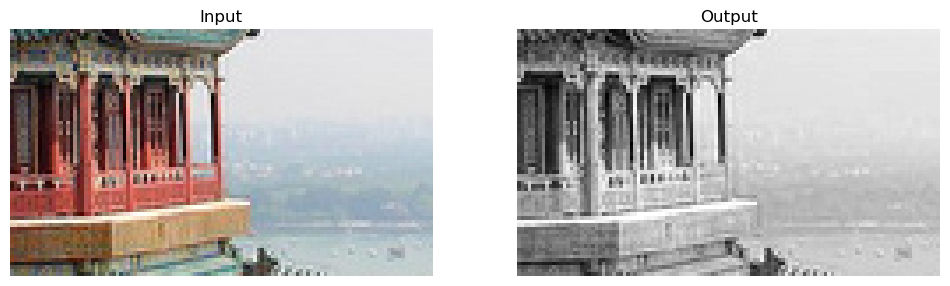

In [60]:
# 3) computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

fig5, ax5 = plt.subplots(1,2, figsize=(12,8))
ax5[0].set_title("Input")
ax5[0].imshow(images[0])  # plot the 1st image
ax5[0].axis("off")

ax5[1].set_title("Output")
ax5[1].imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
ax5[1].axis("off")

- a global average pooling layer computes the mean of each entire feature map
  - outputs a single number per feature map and per instance
    - most of the information in the feature map is lost
    - but can be useful just before the output layer

In [61]:
# 3.  create a global average pooling layer 
# 1) using GlobalAveragePooling2D class, alias GlobalAvgPool2D:

global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

# equivalent to 

global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

# 2) apply it on the images
# get the mean intensity of red, green, and blue for each image
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

# CNN Architectures
- stack (p12) of
  - several `convolutional-pooling` layers each consists of
    - a few convolutional layers (each one generally followed by a ReLU layer) then a pooling layer
  - a regular feedforward neural network
    - composed of a few fully connected layers (+ReLUs)
  - and the final layer outputs the prediction 
    - e.g., a softmax layer that outputs estimated class probabilitie
- `practice`:  stack of two layers with 3 × 3 kernels is better than a single convolutional layer with a 5 × 5 kernel
  - the former uses fewer parameters, requires fewer computations, and usually performs better

In [62]:
# 1. Tackling Fashion MNIST With a CNN
# 1) loads the mnist dataset, add the channels axis to the inputs,
#    scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [64]:
# 2) implement a basic CNN 
# fix some default formal parameters
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

#  the number of filters doubles as we climb up the CNN toward the output layer
# since the number of low-level features is often fairly low
# but there are many different ways to combine them into higher-level features
#  since a pooling layer divides each spatial dimension by a factor of 2, 
# we can afford to double the number of feature maps in the next layer

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Dense(units=10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 256)        

In [65]:
# 3) fits, evaluates, and uses the model to make predictions
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 117s 67ms/step - loss: 0.7397 - accuracy: 0.7403 - val_loss: 0.3799 - val_accuracy: 0.8646
Epoch 2/10
1719/1719 [==============================] - 123s 71ms/step - loss: 0.4271 - accuracy: 0.8568 - val_loss: 0.3429 - val_accuracy: 0.8788
Epoch 3/10
1719/1719 [==============================] - 132s 77ms/step - loss: 0.3555 - accuracy: 0.8815 - val_loss: 0.2737 - val_accuracy: 0.9024
Epoch 4/10
1719/1719 [==============================] - 126s 73ms/step - loss: 0.3198 - accuracy: 0.8936 - val_loss: 0.2921 - val_accuracy: 0.8964
Epoch 5/10
1719/1719 [==============================] - 119s 70ms/step - loss: 0.2925 - accuracy: 0.9019 - val_loss: 0.2521 - val_accuracy: 0.9058
Epoch 6/10
1719/1719 [==============================] - 119s 69ms/step - loss: 0.2683 - accuracy: 0.9085 - val_loss: 0.2588 - val_accuracy: 0.9052
Epoch 7/10
1719/1719 [==============================] - 118s 69ms/step - loss: 0.2598 - accuracy: 0.9135 - val_loss: 0

# Popular CNN models
- variants of CNN architecture have been developed
  - leading to amazing advances in the field
  - A good measure of this progress is the `error rate` in competitions such as 
    - the [ILSVRC ImageNet challenge](https://image-net.org/challenges/LSVRC/)
  - this `error rate` fell from over 26% to less than 2.3% in just six years
- popular CNN models
  - the classical LeNet-5 architecture
  - several winners of the ILSVRC challenge: 
    - AlexNet (2012), GoogLeNet (2014), ResNet (2015), and SENet (2017)
  - a few more architectures:
    - Xception, ResNeXt, DenseNet, MobileNet, CSPNet, and EfficientNet

LeNet-5
---
- created by `Yann LeCun` in 1998 
- has been widely used for handwritten digit recognition (MNIST)
- had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

- the main difference with more modern classification CNNs is the `activation` functions: 
  - ReLU instead of tanh 
  - softmax instead of RBF

[AlexNet](https://homl.info/80)
---
- won the 2012 ILSVRC challenge by a large margin: 
  - it achieved a top-five error rate of 17%
- developed by Alex Krizhevsky (hence the name), Ilya Sutskever, and `Geoffrey Hinton`
- similar to LeNet-5, only much larger and deeper
- the first to stack convolutional layers directly on top of one another
  - instead of stacking a pooling layer on top of each convolutional layer
- had the following layers:

Layer  | Type            | Maps | Size     | Kernel size |
-------|-----------------|------|----------|-------------|
 Out   | Fully connected | –    | 1,000       | –           |
 F10   | Fully connected | –    | 4,094       | –           |
 F9    | Fully connected | –    | 4,096       | –           | 
 S8    | Max pooling     | 256  | 6 × 6       | 3 × 3       |
 C7    | Convolution     | 256  | 13 × 13     | 3 × 3       |  
 C6    | Convolution     | 384  | 13 × 13     | 3 × 3       |
 C5    | Convolution     | 384  | 13 × 13     | 3 × 3       |
 S4    | Max pooling     | 256  | 13 × 13     | 3 × 3       |
 C3    | Convolution     | 256  | 27 × 27     | 5 × 5       |
 S2    | Max pooling     | 96   | 27 × 27     | 3 × 3       |
 C1    | Convolution     | 96   | 55 × 55     | 11 × 11     |
 In    | Input           |3(RGB)| 227 × 227   | –           |

- used two regularization techniques to reduce overfitting
  - dropout with a 50% dropout rate during training to the outputs of layers F9 and F10
  - data augmentation (p13) by randomly shifting the training images by various offsets, 
    - flipping them horizontally, and changing the lighting conditions
    - some could be done with Keras’s data augmentation layers such as
      - RandomCrop, RandomRotation, etc.
- used a competitive normalization step immediately after the ReLU step of layers C1 and C3
  - called local response normalization (LRN)
  - the most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps
  - Such competitive activation has been observed in biological neurons 
  - This encourages different feature maps to specialize
    - pushing them apart and forcing them to explore a wider range of features
    - ultimately improving generalization
  - equation of LRN (p14-15)

[GoogLeNet](https://homl.info/81)
---
- developed by Christian Szegedy et al. from Google Research
- won the ILSVRC 2014 challenge by pushing the top-five error rate below 7%
  - thanks to that the network was much deeper than previous CNNs, and
  - `inception modules`  allow GoogLeNet to use parameters much more efficiently than previous architectures
    - GoogLeNet actually has 10 times fewer parameters than AlexNet
  - the whole `inception module` is able to output feature maps that capture complex patterns at various scales
    - as a convolutional layer on steroids
- in the `inception modules`, convolutional layers 
  - use different kernel sizes to capture patterns at different scales
  - those with 1 × 1 kernels can capture patterns along the depth dimension
  - configured to output fewer feature maps than their inputs
    - reduce dimensionality, speed up training and improve generalization
  - pair into powerful convolutional layers to capture more complex patterns
- the architecture of the GoogLeNet CNN (p17)

[VGGNet](https://homl.info/83)
---
- developed by Karen Simonyan and Andrew Zisserman, from the Visual Geometry Group (VGG) research lab at Oxford University
- a very simple and classical architecture of  a total of 16 or 19 convolutional layers, depending on the VGG variant
  - 2 or 3 convolutional layers and a pooling layer, 
  - then again 2 or 3 convolutional layers and a pooling layer, and so on
  - a final dense network with 2 hidden layers and the output layer
- used many small 3 × 3 filters

[ResNet](https://homl.info/82)
---
- a Residual Network (ResNet)⁠ developed by Kaiming He et al. that delivered an astounding top-five error rate under 3.6%
- won the ILSVRC 2015 challenge
  - used an extremely deep CNN composed of 152 layers
- confirmed the general trend: 
  - computer vision models were getting deeper and deeper, but with fewer and fewer parameters
- The key of training such a deep network:
  - use (p18) `skip connections` (also called `shortcut connections`): the signal feeding into a  layer is also added to the output of a layer located higher up the stack
- if `skip connection` adds the input `x` to the output of a network which models a target function `h(x)`, then it models `f(x)=h(x)-x`. This is called `residual learning`.
  - so it initially models the `identity function`
  - If the target function is fairly close to the identity function,
    - which is often the case
  - this will speed up training considerably
- (p19) The `deep residual network` can be seen as a stack of `residual units (RUs)`
  - where each RU is a small nn with a skip connection
  - this helps the signal easily make its way across the whole network
  - so the network can start making progress even if several layers have not started learning yet
- (p20) `ResNet’s architecture` starts and ends exactly like GoogLeNet
  - except without a dropout layer
  - in between is just a very deep stack of residual units
  - Each residual unit is composed of 
    - two convolutional layers (and no pooling layer!), 
    - with batch normalization (BN) and ReLU activation, 
    - using 3 × 3 kernels and preserving spatial dimensions (stride 1, "same" padding)
- the number of feature maps is doubled every few residual units, 
  - at the same time as their height and width are halved (using a convolutional layer with stride 2)
  - When this happens, the inputs cannot be added directly to the outputs of the residual unit because they don’t have the same shape (the dash arrow in p20)
  - (p21) solved by passing the inputs through a 1 × 1 convolutional layer with stride 2 and the right number of output feature maps
- `other variants` of ResNet had 34, 50, and 101 layers, e.g.
  - ResNet-34 is a ResNet with 34 layers (only counting the convolutional layers and the fully connected layer)
    - containing 3 RUs that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps
  - ResNets deeper than 34, such as ResNet-152, use slightly different residual units
    - they use three convolutional layers: first a 1 × 1 convolutional layer with just 64 feature maps (4 × less)
      - which acts as a bottleneck layer (as discussed already), 
    - then a 3 × 3 layer with 64 feature maps, 
    - and finally another 1 × 1 convolutional layer with 256 feature maps (4 times 64) that restores the original depth. 
  - ResNet-152 contains 3 such RUs that output 256 maps, 
    - then 8 RUs with 512 maps, a whopping 36 RUs with 1,024 maps, 
    - and finally 3 RUs with 2,048 maps

[Xception](https://homl.info/xception)
---
- short for `extreme Inception`, another variant of the GoogLeNet architecture
- proposed by `François Chollet` (the author of Keras) in 2016 
- significantly outperformed `Inception-v3` on a huge vision task (350 million images and 17,000 classes)
- Just like Inception-v4, it merges the ideas of GoogLeNet and ResNet, 
  - (p22) but it replaces the inception modules with a special type of layer called a `depthwise separable convolution layer` (or `separable convolution layer` for short⁠) composed of two parts: 
    - the first part applies `a single spatial filter` to each input feature map 
    - then the second part looks exclusively for `cross-channel patterns`
      - just a regular convolutional layer with 1 × 1 filters 
    - with assumption that `spatial patterns` and `cross-channel patterns` can be modeled separately
  - While a regular convolutional layer uses filters that try to simultaneously capture spatial patterns and cross-channel patterns
- the `Xception architecture` starts with 2 regular convolutional layers,
  - but then the rest of the architecture uses only separable convolutions (34 in all), 
  - plus a few max pooling layers 
  - and the usual final layers (a global average pooling layer and a dense output layer)

[Squeeze-and-Excitation Network (SENet)](https://homl.info/senet)
---
- won the ILSVRC 2017 challenge
- extends existing architectures such as inception networks and ResNets and boosts their performance by
  - (p23) adding a small neural network called `SE block` to every inception module or residual unit in the original architecture
- The extended versions of inception networks and ResNets are called SE-Inception and SE-ResNet respectively
- (p24) An SE block analyzes the output of the unit it is attached to
  - focuses exclusively on the depth dimension without looking for any spatial pattern 
  - learns which features are usually most active together,
    - then uses this information to recalibrate the feature maps
- (p25) An SE block is composed of just three layers: 
  - a global average pooling layer
    - computes the `mean activation` for each feature map
  - a hidden dense layer using the ReLU activation function
    - has neurons typically 16 times fewer than the number of feature maps
      - This is a low-dimensional vector representation (i.e., an `embedding`) of the distribution of feature responses
    - forces the SE block to learn a general representation of the feature combinations
  - and a dense output layer using the sigmoid activation function
    - takes the embedding and outputs a `recalibration` vector containing one number (between 0 and 1) per feature map
    - then multiplies the feature maps by this recalibration vector
      - irrelevant features (with a low recalibration score) get scaled down
      - relevant features (with a recalibration score close to 1) are left alone

other noteworthy CNN architectures
---
- [ResNeXt](https://homl.info/resnext)
  - improves the residual units in ResNet to be
    - many parallel stacks with 3 convolutional layers each
  - the outputs of all the stacks are added together, and the result is passed to the next residual unit
- [DenseNet](https://homl.info/densenet)
  - composed of several dense blocks, 
    - each made up of a few densely connected convolutional layers separated by a few transition layers
  - The output of each layer is fed as input to every layer after it within the same block
- [MobileNet](https://homl.info/mobilenet)
  - based on depthwise separable convolutional layers, like Xception
  - lightweight and fast 
  - targets mobile and web applications
- [Cross Stage Partial Network (CSPNet)](https://homl.info/cspnet)
  - similar to a DenseNet
  - but part of each dense block’s input is concatenated directly to that block’s output
    - without going through the block
- [EfficientNet](https://homl.info/efficientnet)
  - the `most important model` in this list
  - starts from a scaled-down version of ImageNet (with smaller and fewer images) found by `neural architecture search`
  - then scales this version with `compound scaling`
    - by jointly increasing the depth (number of layers), 
    - width (number of filters per layer), 
    - and resolution (size of the input image)

Choosing the Right CNN Architecture
---
- the [best pretrained models](https://keras.io/api/applications) currently available in Keras
- defined in the `tf.keras.applications` package
  - here `application` means `ml model` in ML

In [4]:
# 1. implement a ResNet-34 from scratch with Keras
# Most CNN architectures above can be implemented using Keras

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

# 1) create a ResidualUnit layer:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [5]:
# 2) build a ResNet-34 using a Sequential model
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                        

In [7]:
# 2. Using Pretrained Models from Keras in the tf.keras.applications package
# 1)  load the ResNet-50 model, pretrained on ImageNet
#   
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 142s 1us/step


In [10]:
# 2) A ResNet-50 model expects 224 × 224–pixel images
# resize two sample images using Keras’s Resizing layer

images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

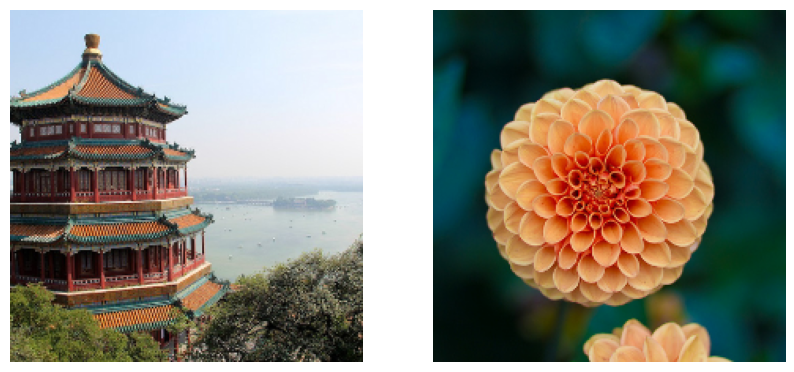

In [15]:
# show the two sample images
fig6, ax6 = plt.subplots(1,2, figsize=(10,6))
for i in (0, 1):
    ax6[i].imshow(images_resized[i] / 255)
    ax6[i].axis("off")

In [11]:
# 3) The pretrained models provides a preprocess_input() function 
#   - to scale normal image pixel values range from 0 to 255
#   - to normalized values from 0 to 1, or from –1 to 1, etc.
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [12]:
# 4) make predictions
Y_proba = model.predict(inputs)
Y_proba.shape # one row per image and one column per class 
# (in this case, there are 1,000 classes)

1/1 [==============================] - 1s 839ms/step


(2, 1000)

In [13]:
# 5) display the top K predictions with `decode_predictions()` function
# including the class name and the estimated probability of each predicted class
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 [==============================] - 0s 3us/step
Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


- The correct classes are palace and dahlia, 
  - so the model is correct for the first image but wrong for the second
  - However, that’s because dahlia is not one of the 1,000 ImageNet classes

In [18]:
# 3.  Transfer learning - reuse the lower layers of a pretrained mode
#   train a model to classify pictures of flowers, 
#     reusing a pretrained Xception mode

# 1)  load the flowers dataset using TensorFlow Datasets
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

2024-03-17 17:50:58.339653: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/qingshan/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [19]:
dataset_size, class_names, n_classes

(3670, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

In [20]:
# 2) split the dataset
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

2024-03-17 19:24:07.011676: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


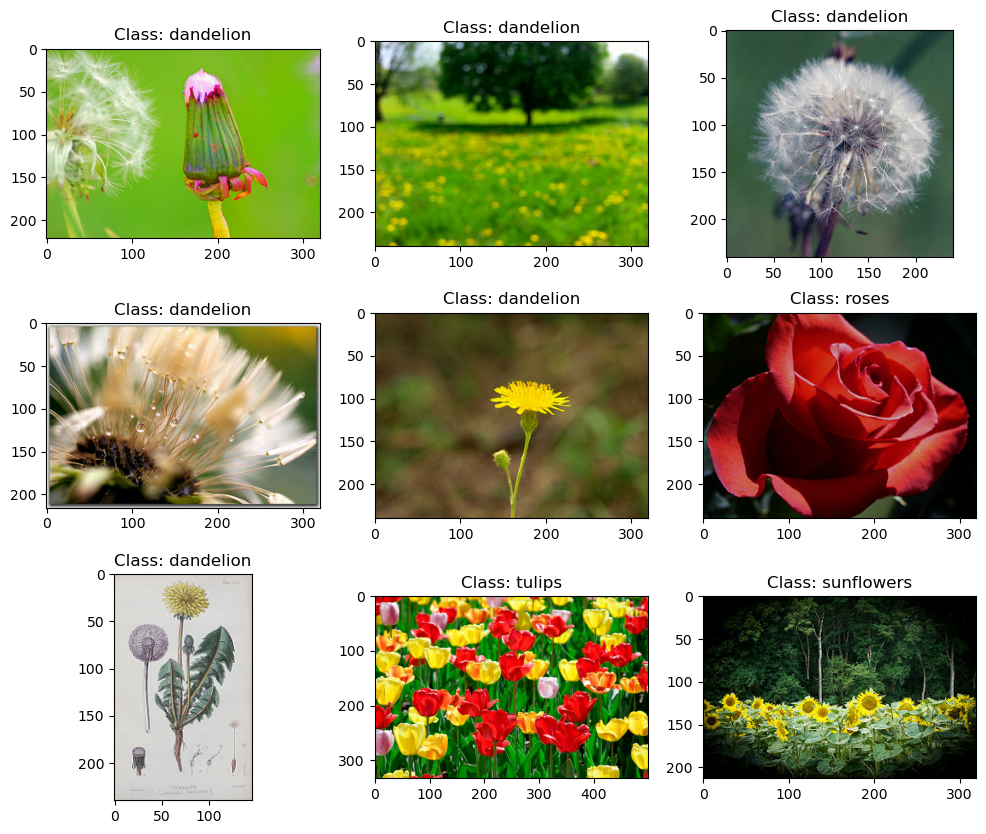

In [22]:
# 3) display the first 9 images in the validation set
# their sizes are different!
fig7, ax7 = plt.subplots(3,3, figsize=(12,10))
index = 0
for image, label in valid_set_raw.take(9):
    ax7[index//3, index%3].imshow(image)
    ax7[index//3, index%3].set_title(f"Class: {class_names[label]}")
    index += 1


In [23]:
# 4) preprocess the dataset
# resize and shuffle to ensure they all have the same size, or batching will fail

tf.keras.backend.clear_session()  #  resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

2024-03-17 19:33:13.230362: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


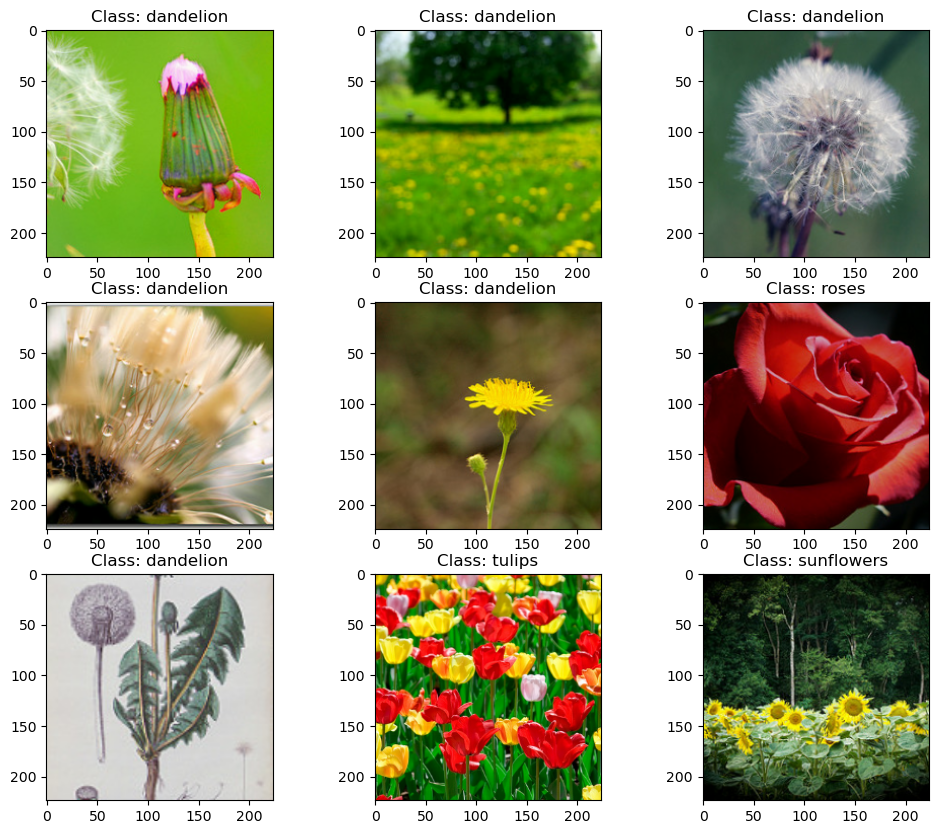

In [25]:
# 5) re-display the first 9 images in the validation set
# now each batch contains 32 images, all of them 224 × 224 pixels, 
# with pixel values ranging from –1 to 1

fig8, ax8 = plt.subplots(3,3, figsize=(12,10))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        ax8[index//3, index%3].imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        ax8[index//3, index%3].set_title(f"Class: {class_names[y_batch[index]]}")

In [26]:
# 6) image augmentation
# randomly flip the images horizontally,
# rotate them a little bit, and tweak the contrast during training

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(factor=0.05),
    tf.keras.layers.RandomContrast(factor=0.2)
])

2024-03-17 19:41:44.627945: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


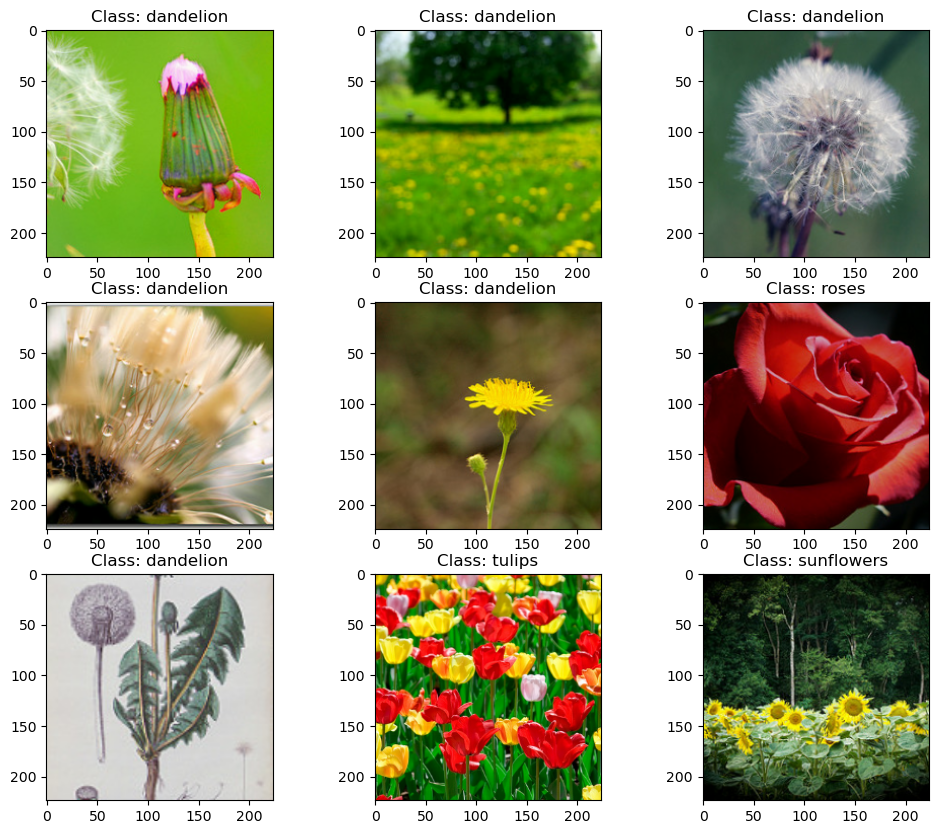

In [29]:
# apply the `data_augmentation` above on the valid_set
# run multiple times to see different random data augmentations
fig9, ax9 = plt.subplots(3,3, figsize=(12,10))
for X_batch, y_batch in valid_set.take(1):
  X_batch_augmented = data_augmentation(X_batch, training=True)
  for index in range(9):
      ax9[index//3, index%3].imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
      ax9[index//3, index%3].set_title(f"Class: {class_names[y_batch[index]]}")

In [30]:
# 7) build our flower classification model on the pretrained model 
# without its top layers
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)

# add our own global average pooling layer (feeding it the output of the base model), 
# followed by a dense output layer with one unit per class, 
# using the softmax activation function
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 42s 1us/step


In [31]:
# 8) freeze the weights of the pretrained layers
# Since our model uses the base model’s layers directly, 
# rather than the base_model object itself, 
# setting base_model.trainable=False would have no effect.
for layer in base_model.layers:
    layer.trainable = False

In [32]:

# 9) compile the model and start training
#   while keeping the base model weights fixed
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 105s 1s/step - loss: 0.7675 - accuracy: 0.8070 - val_loss: 0.6394 - val_accuracy: 0.8457
Epoch 2/3
86/86 [==============================] - 108s 1s/step - loss: 0.2959 - accuracy: 0.9182 - val_loss: 0.5798 - val_accuracy: 0.8421
Epoch 3/3
86/86 [==============================] - 126s 1s/step - loss: 0.1846 - accuracy: 0.9400 - val_loss: 0.6349 - val_accuracy: 0.8603


In [33]:
# show the model layers
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [34]:
# 10) unfreeze some of the base model’s top layers, then continue training
# unfreeze layers 56 and above (that’s the start of residual unit 7 out of 14 as above)
for layer in base_model.layers[56:]:
    layer.trainable = True

# use a much lower learning rate to avoid damaging the pretrained weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 254s 3s/step - loss: 0.3040 - accuracy: 0.9033 - val_loss: 0.6657 - val_accuracy: 0.8312
Epoch 2/10
86/86 [==============================] - 271s 3s/step - loss: 0.0393 - accuracy: 0.9887 - val_loss: 0.3609 - val_accuracy: 0.9038
Epoch 3/10
86/86 [==============================] - 270s 3s/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.3107 - val_accuracy: 0.9074
Epoch 4/10
86/86 [==============================] - 270s 3s/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.2698 - val_accuracy: 0.9093
Epoch 5/10
86/86 [==============================] - 273s 3s/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.2652 - val_accuracy: 0.9201
Epoch 6/10
86/86 [==============================] - 269s 3s/step - loss: 0.0038 - accuracy: 0.9982 - val_loss: 0.2800 - val_accuracy: 0.9129
Epoch 7/10
86/86 [==============================] - 268s 3s/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.2942 - val_accuracy: 0.9147
Epoch 8/10
86

# Classification and Localization
- Localizing an object in a picture can be expressed as a regression task:
  - to predict a `bounding box` around the object, a common approach is to predict 
    - the `horizontal and vertical coordinates` of the object’s `center` 
    - as well as its `height and width`
  - four numbers need to predict
- just need to add a second dense output layer with four units 
  - typically on top of the global average pooling layer
  - and it can be trained using the `MSE loss`
- However, the flowers dataset does not have bounding boxes around the flowers (i.e. unlabelled)
  - open source tools used to annotate images with bounding boxes:
    - VGG Image Annotator, LabelImg, OpenLabeler, or ImgLab
  - or crowdsourcing platforms such as Amazon Mechanical Turk 
    - for a very large number of images to annotate
- (p26) better metric than MSE: 
  - `intersection over union (IoU)`: the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union

In [ ]:
# 1. create a model predicting flower type and its bounding box
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# 2. fits the model using random target bounding boxes
# in real life you would need to create proper targets instead

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

# Object Detection
- classifies and localizes multiple objects in an image
- methods:
  - 🅐 (p27) a `sliding CNN` manually slides across the image and makes predictions at each step
    - outputs `class probabilities`, `a bounding box`, and `an objectness score`: 
      - the `objectness score` is the estimated probability that the image does indeed contain an object centered near the middle
    - straightforward but often detect the same object multiple times at slightly different positions
    - several views with different sizes are needed to detect objects with varying sizes
    - `non-max suppression` is commonly used to get rid of all the unnecessary bounding boxes
      - ❶ get rid of all the bounding boxes for which the objectness score is below some threshold
      - ❷ find the remaining bounding box with the highest objectness score
        - and get rid of all the other remaining bounding boxes that overlap a lot with it
          - e.g., with an IoU greater than 60%
      - ❸ Repeat step ❷ until there are no more bounding boxes to get rid of
  - 🅑 (p28) using a [fully convolutional network (FCN)](https://homl.info/fcn) to slide a CNN across an image
    - by looking at the image only once

[You Only Look Once (YOLO)](https://github.com/ultralytics/ultralytics)
---
- a fast and accurate object detection architecture proposed by [Joseph Redmon et al.](https://homl.info/yolo)
  - so fast that it can run in real time on a [video](https://homl.info/yolodemo)
- similar to 🅑 above with a few important differences
  - bounding box center lies within each grid cell
    - bounding box coordinates are relative to that cell
  - It outputs two bounding boxes for each grid cell
    - used to handle cases where two objects are so close to each other
  - it outputs a class probability distribution for each grid cell
- Many object detection models are available on [TensorFlow Hub](https://homl.info/objdet)
  - YOLOv5, ⁠SSD,⁠ Faster R-CNN,⁠ and EfficentDet, etc.

Object Tracking
---
- a challenging task: 
  - objects move, they may grow or shrink as they get closer to or further away from the camera, 
  - their appearance may change as they turn around or move to different lighting conditions or backgrounds, 
  - they may be temporarily occluded by other objects, and so on.
- One of the most popular object tracking systems is [DeepSORT](https://homl.info/deepsort) based on a combination of classical algorithms and deep learning:
  - uses `Kalman filters` to estimate object `position`
  - uses a deep learning model to measure the `resemblance` between new detections and existing tracked objects
  - uses the `Hungarian algorithm` to map new detections to existing tracked object

Semantic Segmentation
---
- (p29) classifies each pixel according to the class of the object it belongs to
  - ⚠️ different objects of the same class are not distinguished
- uses `upsampling layers` to increase resolution
- There are several solutions available for upsampling
  - `bilinear interpolation`, but that only works reasonably well up to ×4 or ×8
  - (p30) use a `transposed convolutional` layer equivalent to 
    - first stretching the image by inserting empty rows and columns (full of zeros)
    - then performing a regular convolution⁠
- (p31) `super-resolution` through `skip connection`

Instance segmentation
---
- similar to semantic segmentation
  - but instead of merging all objects of the same class into one big lump
  - each object is distinguished from the others
- The field is moving fast
  - [many models](https://paperswithcode.com/) come out every year

New directions of deep computer vision
---
- the field of deep computer vision is vast and fast-paced
  - most models are based on CNNs
  - transformers entered this field since 2020
- new directions
  - `adversarial learning`
    - attempts to make the network more resistant to images designed to fool it
  - `explainability` 
    - explains why the network works
  - `realistic image generation`
  - `single-shot learning`
    - recognizes an object after saw it just once